Author: Tri Doan   
    This prototype illustrates a common work in business analytic to learn how a new feature of product/ service to bring up the revenue. For example, company wants to know whether or not subcribers change if a new feature/ a new design in their page is introduced. Since it will be used as a guide line for other similar work, we will include some theory knowledge associated with it. 


- A/B Test: A long approach- a walk through how to A/B with Null Hypothesis
- A/B Test: a practice to evaluate Null hypothese
- Regression - an alternately solution 



In [2]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

random.seed(42)

`1.` Data used, `ab_data.csv` collected by random sampling users into two groups: control and variable. **Control** indicates its user recieve old/ traditional page while **treament** introduces to its user a new page with new featureStor.We recorded that users react to the page. If they clicks on page, we consider a `hit` that leads to a conversion (often consider conversion rate).

In [3]:
os.chdir("C:/Projects_repository/Analyze_AB_test")
# read dataset
df = pd.read_csv('ab_data.csv')

# inspect dataset
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [9]:
print("Number of data points = {}".format(df.shape[0]))

Number of data points = 294478


In [6]:
print("Number of unique users is : {}".format(df.nunique()['user_id']))

Number of unique users is : 290584


d. The proportion of users converted.

In [34]:
print("Percentage of conversion {:4.2f}".format(sum(df['converted'])/df.shape[0]))

Percentage of conversion 0.12


Whether of not the `new_page` and `treatment` don't line up. How many?

In [40]:
# rows where treatment group user lands incorrectly on old_page 
mismatch_grp1 = df.query("group == 'treatment' and landing_page == 'old_page'")
print("Times treatment group user lands incorrectly on old_page is {}".format(len(mismatch_grp1)))

# rows where control group user incorrectly lands on new_page
mismatch_grp2 = df.query("group == 'control' and landing_page == 'new_page'")
print("Times control group user incorrectly lands on new_page is {}".format(len(mismatch_grp2)))

#  number of times the new_page and treatment don't line up is sum of above two values
print("Times new_page and treatment don't line up is {}".format(len(mismatch_grp1) + len(mismatch_grp2)))

Times treatment group user lands incorrectly on old_page is 1965
Times control group user incorrectly lands on new_page is 1928
Times new_page and treatment don't line up is 3893


Do any of the rows have missing values?

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


All seen from above figures, no values are missing.

For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we suspect that incorrect data and need to remove.

In [42]:
# Remove the mismatched data
df.drop(df.query("group == 'treatment' and landing_page == 'old_page'").index, inplace=True)
# drop rows for mismatched control groups
df.drop(df.query("group == 'control' and landing_page == 'new_page'").index, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 0 to 294477
Data columns (total 5 columns):
user_id         290585 non-null int64
timestamp       290585 non-null object
group           290585 non-null object
landing_page    290585 non-null object
converted       290585 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


In [43]:
df.to_csv('ab_edited.csv', index=False)

In [44]:
# read newly created dataset into another dataframe
df= pd.read_csv('ab_edited.csv')

In [45]:
# Double Check all of the correct rows were removed - this should be 0
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].shape[0]

0

Any dupplicate **user_id**.  What is it?

In [46]:
# check if duplicates in user_id
# we know that one user id is repeated due to difference between #userids and #unique ids
sum(df['user_id'].duplicated())

1

Close look of the repeat **user_id**? 

In [49]:
#investigate details of rows with duplicate user ids
df[df.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1876,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2862,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


There may be the same user open a new page on the same site. Let remove **one** of the rows with a duplicate **user_id**

In [50]:
time_dup = "2017-01-09 05:37:58.781806"
df = df[df.timestamp != time_dup]

In [25]:
# No more duplicate user ids
len(df['user_id'].unique())

290584

There are several question can be made till now   
- what is the probability they converted? in each group?

In [54]:
df.groupby('group').describe()

converted                                                user_id  \
              count      mean       std  min  25%  50%  75%  max     count   
group                                                                        
control    145274.0  0.120386  0.325414  0.0  0.0  0.0  0.0  1.0  145274.0   
treatment  145310.0  0.118808  0.323564  0.0  0.0  0.0  0.0  1.0  145310.0   

                                                                       \
                    mean           std       min        25%       50%   
group                                                                   
control    788164.072594  91287.914601  630002.0  709279.50  788128.5   
treatment  787845.719290  91161.564429  630000.0  708745.75  787876.0   

                                
                 75%       max  
group                           
control    867208.25  945998.0  
treatment  866718.75  945999.0

The conversion rate of `control` is 0.120386  while it is 0.118807 in `treatment`

What is the probability that an individual received the new page?

In [60]:
len(df[df['group']=='treatment'])/len(df)

0.5000619442226688

**Evidence that one page leads to more conversions?**
- Change aversion, test span durations and other potentially influencing factors are not accounted for. So, we cannot state with certainty that one page leads to more conversions. This is even more important due to almost similar performance of both pages.
- This leads to the use of following A/B test.

<a id='ab_test'></a>
### Statistic - A/B Test: a long approach

Notice that because of the time stamp associated with each event, a question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

Consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Hypothesis**
- $H_{0}$ : $p_{new}$ <= $p_{old}$  
- $H_{1}$ : $p_{new}$ > $p_{old}$ 

Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in data regardless of the page. Furthermore, we use a sample size for each page equal  <br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br>

The **convert rate** for $p_{new}$ under the null? It is also a convert rate for $p_{old}$ under the null

In [77]:
p_new=df['converted'].mean()
p_new
p_old=p_new

What is $n_{new}$?

In [71]:
n_new =len(df.query("group == 'treatment'"))
n_new

145310

d. What is $n_{old}$?

In [72]:
n_old= len(df.query("group == 'control'"))
n_old

145274

Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  

In [80]:
new_page_converted = np.random.choice([1, 0], size=n_new, p=[p_new, (1-p_new)])
len(new_page_converted)

145310

Silimarly, simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null. 

In [81]:
old_page_converted = np.random.choice([1, 0], size=n_old, p=[p_old, (1-p_old)])
len(old_page_converted)

145274

To find the difference $p_{new}$ - $p_{old}$, we can use only the same amount of data point of 145274

In [83]:
new_page_converted = new_page_converted[:145274]
p_diff = (new_page_converted/n_new) - (old_page_converted/n_old)
p_diff

array([0.00000000e+00, 6.88183883e-06, 0.00000000e+00, ...,
       0.00000000e+00, 6.88183883e-06, 0.00000000e+00])

We will repeat the same process to obtain 10,000 $p_{new}$ - $p_{old}$ values **p_diffs**.

Note that size is different for n_new and n_old .Either we use the equal size of datapoint as above or an average value for both old and new page conversion simulations to overcome this problem of shape difference. 

In [86]:
p_diffs = []

for _ in range(10000):
    new_page_converted = np.random.choice([1, 0], size=n_new, p=[p_new, (1-p_new)]).mean()
    old_page_converted = np.random.choice([1, 0], size=n_old, p=[p_old, (1-p_old)]).mean()
    diff = new_page_converted - old_page_converted 
    p_diffs.append(diff)
    

Plot a histogram of the **p_diffs**.  

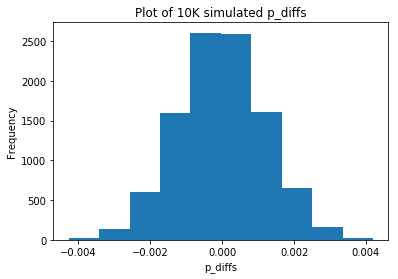

In [87]:
plt.hist(p_diffs)
plt.xlabel('p_diffs')
plt.ylabel('Frequency')
plt.title('Plot of 10K simulated p_diffs');

Compute the proportion of the **p_diffs** from the original data

In [88]:
# compute difference from original dataset ab_data.csv
act_diff = df[df['group'] == 'treatment']['converted'].mean() -  df[df['group'] == 'control']['converted'].mean()
act_diff 

-0.0015782389853555567

In [89]:
p_diffs = np.array(p_diffs)
p_diffs

array([ 0.00067911, -0.00071107,  0.00082349, ..., -0.00124085,
        0.00019737,  0.0007274 ])

In [90]:
# proportion of p_diffs greater than the actual difference observed in ab_data.csv is computed as:
(act_diff < p_diffs).mean()

0.901

Summary: Is there a difference between the new and old pages?

We find that there is no conversion advantage with new pages. We conclude that null hypothesis is true as old and new pages perform almost similarly. Old pages, as the numbers show, performed slightly better.

Alternative, we could also use a built-in to achieve similar results.  Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [92]:
import statsmodels.api as sm

df.head(3) 

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0


In [94]:
convert_old = sum(df.query("group == 'control'")['converted'])
convert_new = sum(df.query("group == 'treatment'")['converted'])
n_old = len(df.query("group == 'control'"))
n_new = len(df.query("group == 'treatment'"))


Compute your test statistic and p-value. 

In [96]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
print(z_score, p_value)

1.3109241984234394 0.9050583127590245


Compute critical value at 95% confidence 

In [97]:
from scipy.stats import norm

print(norm.cdf(z_score))  # how significant our z-score is

# for our single-sides test, assumed at 95% confidence level, we calculate: 
print(norm.ppf(1-(0.05)))

0.9050583127590245
1.6448536269514722


Conclusion:
- We find that the z-score of 1.31092419842 is less than the critical value of 1.64485362695. So, we accept the null hypothesis.


<a id='regression'></a>
Alternative method: A regression approach



**Logistic Regression** can be used if there is a significant difference in conversion based on which page a customer receives. To do this, generate an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [98]:
df['intercept']=1
df[['control', 'treatment']] = pd.get_dummies(df['group'])

Predict whether or not an individual click.

In [99]:
import statsmodels.api as sm
logit = sm.Logit(df['converted'],df[['intercept','treatment']])
results = logit.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 26 Apr 2019   Pseudo R-squ.:               8.077e-06
Time:                        10:57:17   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
treatment     -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

Remember that
- Our hypothesis here is:
- $H_{0}$ : $p_{new}$ - $p_{old}$  = 0
- $H_{1}$ : $p_{new}$ - $p_{old}$  != 0

**More complicated method**

- When may think about different segment of market (group). e.g new customer vs returning customer, male vs female, regions  or seasonality as other factors influence the conversions too. Seasonality like new terms or New years might mean more interest in new skills/ resolutions. Timestamps are inlcuded but without regionality, they do not indicate if seasonality was a factor or not. [as different countries follow different term and weather patterns. 
- Factors like device on which tests were taken or course which was looked at, prior academic background, age, might alter experience and ultimately, conversions. 
Note:   
 small pilots and pivots sometimes work better in practice than long-drawn research without execution. 

In [100]:
countries_df = pd.read_csv('./countries.csv')
countries_df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [102]:
df_new = countries_df.set_index('user_id').join(df.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,control,treatment
user_id,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1


In [103]:
df_new['country'].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [105]:
### Create the necessary dummy variables
df_new[['CA', 'US']] = pd.get_dummies(df_new['country'])[['CA','US']]

df_new['country'].astype(str).value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

We would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [106]:
### Fit Your Linear Model And Obtain the Results
df['intercept'] = 1


log_mod = sm.Logit(df_new['converted'], df_new[['CA', 'US']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.447174
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 26 Apr 2019   Pseudo R-squ.:                 -0.2214
Time:                        11:11:34   Log-Likelihood:            -1.2994e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
CA            -2.0375      0.026    -78.364      0.000      -2.088      -1.987
US            -1.9967      0.007   -292.314      0.000      -2.010      -1.983
==============================================================================
"""

In [107]:
np.exp(results.params)

CA    0.130350
US    0.135779
dtype: float64

In [56]:
1/_

0.00010001000100010001

In [108]:
df.groupby('group').mean()['converted']

group
control      0.120386
treatment    0.118808
Name: converted, dtype: float64

Summary
- As in this logistic regression model too, we find that the values do not show a substantial difference in the conversion rates for control group and treatment group. So we cannot reject Null Hypothesis and keep the existing page as is.

<a id='conclusions'></a>
## Conclusions

- The performance of the old page was found better (by miniscule values only) as computed by different techniques.
- Hence, we accept the Null Hypothesis and Reject the Alternate Hypothesis.
- These inferences are strictly based on data on hand. This analysis acknowledges its limitations due to factors not included in the data. [see part III.f]

### Resources
- Udacity Nanodegree Videos and Resources, including Links in this .ipynb
- https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.duplicated.html
- https://stackoverflow.com/questions/14657241/how-do-i-get-a-list-of-all-the-duplicate-items-using-pandas-in-python
- https://stackoverflow.com/questions/18172851/deleting-dataframe-row-in-pandas-based-on-column-value
- https://youtu.be/7FTp9JJ5DfE : Project Walkthrough Link on Slack's Project Thread
